In [1]:
import yaml
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 20)

from bs4 import BeautifulSoup
from collections import Counter
from itertools import chain, product
import json
import networkx as nx
import pandas as pd
from pandas import DataFrame
from urllib.parse import urlparse
import datetime

from comment_thread import *
from author_network import *

In [2]:
SBSTYLE = 'seaborn-talk'

In [3]:
def process_polymath(project, split=False):
    """Takes name of a PM-project and returns pandas DataFrame"""
    message = "Polymath {}".format(
        project.split(" ")[-1]) if project.startswith("pm") else "Mini\
        Polymath {}".format(project[-1])
    settings = {
        'msg': message,
        'filename': message.replace(" ", ""),
        'source': project.replace(" ", ""),
        'urls': [],
        'type': '',
        'parser': 'html5lib',
        'cmap': plt.cm.Paired, # not a string, this is an object
        'vmin': 1,
        'vmax': 100}

    with open("DATA/" + settings['source'] + ".csv", "r") as input_file:
        pm_frame = pd.read_csv(input_file, index_col="Ord")

    pm_frame['blog'] = pm_frame['url'].apply(
        lambda url: urlparse(url).netloc.split('.')[0].title())
    pm_frame['thread'] = [THREAD_TYPES[blog](url) for (url, blog) in zip(
        pm_frame['url'], pm_frame['blog'])]
    pm_frame['number of comments'] = pm_frame['thread'].apply(
        lambda x: len(x.node_name.keys()))
    pm_frame['number of comments (accumulated)'] = pm_frame[
        'number of comments'].cumsum()

    indices = pm_frame.index
    threads = pm_frame.thread
    pm_frame['mthread (single)'] = pm_frame['thread'].apply(MultiCommentThread)
    pm_frame['mthread (accumulated)'] = Series(
        [MultiCommentThread(*threads[0:i+1]) for i in indices], index=indices)
    pm_frame['network'] = pm_frame['mthread (accumulated)'].apply(
        AuthorNetwork)

    if split:
        r_indices = pm_frame[pm_frame['research']].index
        d_indices = pm_frame[~pm_frame['research']].index
        r_threads = pm_frame[pm_frame['research']].thread
        d_threads = pm_frame[~pm_frame['research']].thread
        pm_frame['r_mthread (accumulated)'] = Series(
            [MultiCommentThread(*r_threads[0:i+1]) for i in r_indices],
            index=r_indices)
        pm_frame['d_mthread (accumulated)'] = Series(
            [MultiCommentThread(*d_threads[0:i+1]) for i in d_indices],
            index=d_indices)
        pm_frame['r_network'] = pm_frame[
            pm_frame['research']]['r_mthread (accumulated)'].apply(
                AuthorNetwork)
        pm_frame['d_network'] = pm_frame[
            ~pm_frame['research']]['d_mthread (accumulated)'].apply(
                AuthorNetwork)
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research',
                                          'number of comments',
                                          'number of comments (accumulated)',
                                          'thread', 'mthread (single)',
                                          'mthread (accumulated)',
                                          'network',
                                          'r_mthread (accumulated)',
                                          'r_network',
                                          'd_mthread (accumulated)',
                                          'd_network'],
                                         axis=1)
    else:
        pm_frame = pm_frame.reindex_axis(['title', 'url', 'blog', 'research',
                                          'number of comments',
                                          'thread', 'mthread (single)',
                                          'mthread (accumulated)', 'network'],
                                         axis=1)

    pm_frame.index = pd.MultiIndex.from_tuples([(settings['msg'], i) for i in indices],
                                               names=['Project', 'Ord'])

    return pm_frame


def get_project_at(project, stage):
    """Helper function that gets a project from a frame.
    Only works if the frame is defined outside the function."""
    return mPM_FRAME.loc[project].iloc[stage] if project.startswith(
        "Mini") else PM_FRAME.loc[project].iloc[stage]

def draw_network(project, stage=-1):
    """Wrapper function for author_network.draw_graph.
    Plots the interaction-network between the commenters in project."""
    get_project_at(project, stage)['network'].draw_graph(project=project)

def draw_centre(project, stage=-1, skips=10, zoom=1):
    """Wrapper function for author_network.draw_centre_discussion"""
    get_project_at(project, stage)['network'].draw_centre_discussion(
        skips=skips, zoom=zoom)

def plot_activity_pie(project, stage=-1):
    """Wrapper function for author_network.plot_author_activity_pie
    Plots pie-chart of comment_activity of commenters is project."""
    get_project_at(project, stage)['network'].plot_author_activity_pie(
        project=project)

def plot_activity_bar(project, stage=-1):
    """Wrapper function for author_network.plot_activity_bar
    Plots bar-chart of comment_activity of commenters in project"""
    get_project_at(project, stage)['network'].plot_author_activity_bar(
        project=project)

def plot_degree_centrality(project, stage=-1):
    """Wrapper function for author_network.plot_degree_centrality
    Plots line-chart of degree-centrality of commenters in project"""
    get_project_at(project, stage)['network'].plot_degree_centrality(
        project=project)

def plot_activity_degree(project, stage=-1):
    """Wrapper function for author_network.plit_activity_degree
    Plots superposition of bar-chart of comment-activity and line-chart of degree-centrality"""
    get_project_at(project, stage)['network'].plot_activity_degree(
        project=project)

def plot_discussion(project, intervals=10, first=SETTINGS['first_date'],
                    last=SETTINGS['last_date'], stage=-1):
    """Wrapper function for mthread.draw_graph
    Plots structure of discussion in project"""
    get_project_at(project, stage)['mthread (accumulated)'].draw_graph(
        intervals=intervals,
        first=first,
        last=last,
        project=project)

def plot_activity(project, intervals=1, first=SETTINGS['first_date'], last=SETTINGS['last_date'],
                  activity='thread', stage=-1):
    """Wrapper function for mthread.plot_activity
    Plots thread or author activity over time for project"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_activity(
        activity, intervals=intervals,
        first=first,
        last=last,
        project=project)

def plot_growth(project, last=datetime.today(), stage=-1):
    """Wrapper function for mthread.plot_growth
    Plots growth in comments in discussion"""
    get_project_at(project, stage)['mthread (accumulated)'].plot_growth(
        project=project, last=last)

def get_last(lst_of_frames):
    """Helper function which returns the final line for each project
    from a DataFrame"""
    if lst_of_frames == POLYMATHS:
        source = PM_FRAME
        positions = np.array(
            [frame.index.levels[1][-1] for frame in lst_of_frames]
            ).cumsum() + np.arange(len(POLYMATHS))
    elif lst_of_frames == MINIPOLYMATHS:
        source = mPM_FRAME
        positions = np.array(
            [frame.index.levels[1][-1] for frame in lst_of_frames]
            ).cumsum() + np.arange(len(MINIPOLYMATHS))
    else:
        raise ValueError("Need either POLYMATHS or MINIPOLYMATHS")
    source.index = source.index.swaplevel(0, 1)
    data = source.iloc[positions]
    source.index = source.index.swaplevel(1, 0)
    data.index = data.index.droplevel()
    return data, positions

def plot_thread_engagement(project, compress=1, sel=[]):
    """Takes a project as argument, and shows four types of data for each
    thread in bar-plot:
    - y-axis: the average number of comments per participant
        (a measure of how diverse each thread is)
    - width of each bar: the number of comments
    - bar-color: the type of thread
    - text above each bar included in the optional kwarg sel: number of
        comments and number of participants."""
    data = mPM_FRAME.loc[project] if project.startswith("Mini") else PM_FRAME.loc[project]
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df = DataFrame({'research threads': engagement[data['research']],
                    'discussion threads': engagement[~data['research']]},
                   #columns = ['research threads', 'discussion threads'],
                   index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df.index.name = "Threads"
    matplotlib.style.use(SBSTYLE)
    fig = plt.figure()
    axes = df.plot(kind='bar', color=['lightsteelblue', 'steelblue'],
                   title="Community engagement in {}".format(project))
    axes.set_ylabel('average number of comments per participant')
    axes.set_yticklabels([round(1/i, 2) for i in axes.get_yticks()])
    axes.set_xticklabels(data['title'].apply(lambda x: x[:40]), rotation=90, fontsize='small')
    for container in axes.containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
        if i in sel:
            axes.text(engagement.index[i] + .2, engagement[i],
                      "{} comments\n {} commenters".format(
                          data['number of comments'][i], authors[i]),
                      ha="center", va="bottom", fontsize='small')
    plt.tight_layout()

def plot_thread_evolution(project, compress=1, sel=[], sharex=True):
    """takes a project as argument and shows two plots:
    - The bar-plot thread_engagement described above
    - The evolution of the number of participants in each thread (active,
    joined, left) as an area-plot"""
    # data for evolution
    data = mPM_FRAME.loc[project] if project.startswith(
        "Mini") else PM_FRAME.loc[project]
    added = (data['authors'] - data['authors'].shift(1)).apply(
        lambda x: 0 if isinstance(x, float) else len(x))
    removed = (data['authors'].shift(1) - data['authors']).apply(
        lambda x: 0 if isinstance(x, float) else - len(x))
    size = data['authors'].apply(len) - added
    df1 = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                    columns=["joined", "current", "left"], index=data.index)
    df1.index.name = "Threads"
    # data for engagement
    authors = data['authors'].apply(len)
    engagement = authors / data['number of comments']
    df2 = DataFrame({'research threads': engagement[data['research']],
                     'discussion threads': engagement[~data['research']]},
                    #columns = ['research threads', 'discussion threads'],
                    index=data.index)
    sizes = (data['number of comments'] / compress).tolist()
    df2.index.name = "Threads"
    # setting up plot
    matplotlib.style.use(SBSTYLE)
    fig, axes = plt.subplots(2, 1, figsize=(15, 6), squeeze=False, sharex=sharex)
    plt.subplots_adjust(hspace=0.2)
    # plot bottom
    df1.plot(kind="area", ax=axes[1][0], title="",
             color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes[1][0].set_xticks(df1.index)
    axes[1][0].set_xticklabels(data['title'], rotation=90, fontsize='small')
    axes[1][0].set_xlabel("")
    axes[1][0].set_ylabel('active commenters')
    # plot top
    df2.plot(kind='bar', ax=axes[0][0], color=['lightsteelblue', 'steelblue'],
             title="Community engagement in {}".format(project))
    axes[0][0].set_ylabel('comments per participant')
    axes[0][0].set_yticklabels([round(1/i, 2) for i in axes[0][0].get_yticks()])
    axes[0][0].yaxis.get_major_ticks()[0].label1.set_visible(False)
    axes[0][0].set_xticklabels(df2.index, fontsize='small')
    axes[0][0].set_xlabel("")
    for container in axes[0][0].containers:
        for i, child in enumerate(container.get_children()):
            child.set_x(df2.index[i] - sizes[i]/2)
            plt.setp(child, width=sizes[i])
    for i in engagement.index:
        if i in sel:
            axes[0][0].text(engagement.index[i] + .2, engagement[i],
                            "{} comments\n {} commenters".format(
                                data['number of comments'][i], authors[i]),
                            ha="center", va="bottom", fontsize='small')

def plot_community_evolution(project):
    """Takes a project or group of projects ("Polymath" of "MiniPolymath") as
    an argument, and shows the evolution of the number of participants per
    thread or per project in the same manner as the area-plot in
    plot_thread_evolution."""
    if isinstance(project.split()[-1], int):
        as_threads = True
        data = mPM_FRAME.loc[project] if project.startswith(
            "Mini") else PM_FRAME.loc[project]
        added = (data['authors'] - data['authors'].shift(1)).apply(
            lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors'].shift(1) - data['authors']).apply(
            lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"], index=data.index)
        df.index.name = "Threads"
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        added = (data['authors (accumulated)'] -
                 data['authors (accumulated)'].shift(1)).apply(
                     lambda x: 0 if isinstance(x, float) else len(x))
        removed = (data['authors (accumulated)'].shift(1) -
                   data['authors (accumulated)']).apply(
                       lambda x: 0 if isinstance(x, float) else - len(x))
        size = data['authors (accumulated)'].apply(len) - added
        df = DataFrame({'joined' : added, 'left' : removed, 'current': size},
                       columns=["joined", "current", "left"])
        df.index = list(range(1, len(positions) + 1))

    matplotlib.style.use(SBSTYLE)
    fig = plt.figure()
    axes = df.plot(kind="area", title="Community Evolution in {}".format(
        project), color=['sage', 'lightgrey', 'indianred'], stacked=True)
    axes.set_xticks(df.index)
    if as_threads:
        axes.set_xticklabels(data['title'], rotation=90, fontsize='small')
    else:
        xlabels = sorted(data.index, key=lambda x: int(x.split()[-1]))
        axes.set_xticklabels(xlabels, rotation=90, fontsize='small')
    axes.set_ylabel('number of active commenters')

def plot_participation_evolution(project, n=2, skip_anon=True):
    """Takes a project or group of projects ("Polymath" of "MiniPolymath") as
    an argument, and shows for each participant that took part in at least n
    projects/threads the projects/threads (s)he participated in."""
    if project.split()[-1]in ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']:
        as_threads = True
        if project.startswith("Mini"):
            data = mPM_FRAME.loc[project]
        elif project.startswith("Poly"):
            data = PM_FRAME.loc[project]
        else:
            raise ValueError("Need either Polymath or Mini Polymath project")
        all_authors = data.iloc[-1]['authors (accumulated)']
        data = data['authors']
        title = "Participation per thread in {} (at least {} threads)".format(project, n)
    else:
        as_threads = False
        if project.startswith("Mini"):
            data, positions = get_last(MINIPOLYMATHS)
            all_authors = list(ALL_MINI_AUTHORS)
            title = "Participation per project in Mini Polymath (at least {} projects)".format(n)
        elif project.startswith("Poly"):
            data, positions = get_last(POLYMATHS)
            all_authors = list(ALL_AUTHORS)
            title = "Participation per project in Polymath (at least {} projects)".format(n)
        else:
            raise ValueError("Need either Polymath or Mini Polymath")
        data = data['authors (accumulated)']
    indices = data.index.tolist()
    author_project = DataFrame(index=all_authors)
    for ind in indices:
        author_project[ind] = np.zeros_like(author_project.index, dtype=bool)
        for author in data[ind]:
            author_project[ind][author] = True
    author_project = author_project.sort_values(by=indices, ascending=False)
    author_project = author_project.drop("Anonymous") if skip_anon else author_project
    select = author_project.sum(axis=1) >= n
    matplotlib.style.use('seaborn-notebook')
    factor = 30 - len(indices) if len(indices) <= 30 else 40 - len(indices)
    colors = [plt.cm.Set1(factor*i) for i in range(len(indices))]
    author_project.loc[select].plot(kind="bar", stacked=True, color=colors,
                                    title=title)

In [4]:
PM1_FRAME = process_polymath("pm 1", split=True)
PM2_FRAME = process_polymath("pm 2", split=True)
PM3_FRAME = process_polymath("pm 3", split=True)
PM4_FRAME = process_polymath("pm 4", split=True)
PM5_FRAME = process_polymath("pm 5", split=True)
PM6_FRAME = process_polymath("pm 6", split=True)
PM7_FRAME = process_polymath("pm 7", split=True)
PM8_FRAME = process_polymath("pm 8", split=True)
PM9_FRAME = process_polymath("pm 9", split=True)
PM10_FRAME = process_polymath("pm 10", split=True)
PM11_FRAME = process_polymath("pm 11", split=True)

In [6]:
POLYMATHS = [PM1_FRAME, PM2_FRAME, PM3_FRAME, PM4_FRAME, PM5_FRAME, PM6_FRAME, PM7_FRAME, PM8_FRAME, PM9_FRAME, PM10_FRAME, PM11_FRAME]
COL_ORDER = PM1_FRAME.columns.tolist()
PM_FRAME = pd.concat(POLYMATHS)[COL_ORDER]
PM_FRAME['authors'] = PM_FRAME['thread'].apply(lambda thread: thread.authors)
PM_FRAME['authors (accumulated)'] = PM_FRAME['network'].apply(lambda network: set(network.author_frame.index))
ALL_AUTHORS = set.union(*PM_FRAME['authors'].tolist())

# Polymath again (and differently)
### Patrick Allo
#### Oxford Internet Institute

## Overview

1. begin
2. go one
3. yet more
4. get done

## What is Polymath and why does it matter?

+ (Massive) open collaborative mathematics project initiated by Tim Gowers in February 2009.

+ Polymath 1 was devoted to the task of finding an elementary proof of the *Density Hales-Jewett Theorem*.

+ Probable success was announced less than 6 weeks after the start of the project.

+ Results were published under the name "D.H.J. Polymath".

+ Still active: Polymath 10 and 11 started in the past few months.

+ Several projects were successful and led to direct and indirect publications (some failed early).

+ Small mini-projects based on questions from Math Olympiad final questions.

## For the philosophy of mathematical practice

+ A large record of mathematical practice in action.

+ A continuous reflection on the process by several participants, and especially by the more prominent participants (Gowers, Tao, Nielsen).

+ A new type of mathematics and a new type of collaboration?

+ A new example of ICT-mediated mathematics?

+ Broader context: HoTT, theorem-provers and assistants, e-research, citizen science...

## For social epistemology

+ Look at what actually happens instead of at a priori models of collaboration.

+ Accessible to computational methods.

+ Opportunity to mix theoretical insights with empirical study.

## Why again?

+ A lot has already been written by Timothy Gowers (Gowers & Nielsen. 2009. Massively collaborative mathematics. *Nature* 46.) himself, and by Michael Nielsen in "Reinventing discovery : the new era of networked science".

+ Polymath attracted a lot of attention, even in more popular venues like New Scientist.

+ Quantitative and social network analysis of Polymath 1 by Cranshaw & Kittur (2011).

+ Studied within the "Social Machine of Mathematics" project by Pease and Martin.

+ More publications by: Varshney (2012), Stefaneas & Vandoulakis (2012).

+ Van Bendegem, J.P., 2014, Logic, Methodology and Philosophy of Science. Proceedings of the 14th International Congress (Nancy). Logic and Science Facing the New Technologies, Mathematics and the new technologies, part III: The cloud and the web of proofs. College Publications,  London, pp. 427-39.
+ Allo, P., Bendegem, J.P.V. & Kerkhove, B.V. 2013, Mathematical Arguments and Distributed Knowledge, in Abderdein & Dove (eds), The Argument of Mathematics, Springer Netherlands, Dordrecht, pp. 339-60.

## More and better!

+ Still active and growing...
    + Polymath 10 on the "Erdos-Rado Sunflower problem" (Gil Kalai) started in November 2015.
    + Polymath 11 on "Frankl’s union-closed conjecture" (Gowers) officially started a few weeks ago.

+ Better theoretical insight in e-science, but also for the study of research-communities.

+ Situate Polymath within the broader context of e-research and citizen science (an outlier in both fields).

+ Empirical study informed by better theoretical models. (Not simply *retelling the story*)

## Tools and methods

+ Synergy between the philosophy of mathematical practice, social epistemology and the study of scientific communities, and sociology of e-research.

+ Complementing computational social science with insights and concepts from formal models of interaction.

+ Two-way interaction between data-driven analysis and formal modelling:
    1. Use insight in the data to develop formal models.
    2. Use insight from formal models as a typology of valuable patterns of interaction.

### The details

+ Web-scraping with `BeautifullSoup`.
+ Network analysis with `networkx`.
+ `Pandas` for its convenient `DataFrame` and `Series` data-structures.
+ `Matplotlib` and `Seaborn` for visualisation.

Information from the discussion-threads is stored in two types of directed-graphs:
+ Discussion-threads, with comments as nodes and child-parent links as directed edges.
+ Author-networks (or interaction networks), with authors as nodes and weighted directed edges as interactions.

+ Polymath-style blog-mathematics became possible because of the availability of a LaTeX-plugin for WordPress, but precisely the LaTeX-content is a blind-spot in this inquiry.

+ Agent-based modelling and communities as graphs (Zollman).
+ Insights from logics for multi-agent systems:
    + Dynamic epistemic logic.
    + Logics for teamwork (Dunin-Keplicz & Verbrugge).

## The Polymath Projects

+ **Polymath1:** New proofs and bounds for the density Hales-Jewett theorem. Initiated Feb 1, 2009; research results have now been <span style="color:red">published<span>.
+ **Polymath2:** Must an “explicitly defined” Banach space contain $c_0$ or $l_p$? Initiated Feb 17, 2009; attempts to relaunch via wiki, June 9 2010.
+ **Polymath3:** The polynomial Hirsch conjecture. Proposed July 17, 2009; launched, September 30, 2010.
+ **Polymath4:** A deterministic way to find primes. Proposed July 27, 2009; launched Aug 9, 2009. Research results have now been <span style="color:red">published<span>.
+ **Polymath5:** The Erdős discrepancy problem. Proposed Jan 10, 2010; launched Jan 19, 2010. Activity ceased by the end of 2012, but <span style="color:red">results from the project were used to solve the problem in 2015</span>.
+ **Polymath6:** Improving the bounds for Roth's theorem. Proposed Feb 5, 2011. <span style="color:red">Partial result published by non-participant</span>
+ **Polymath7:** Establishing the Hot Spots conjecture for acute-angled triangles. Proposed, May 31st, 2012; launched, Jun 8, 2012.
+ **Polymath8:** Improving the bounds for small gaps between primes. Proposed, June 4, 2013; launched, June 4, 2013. Research results have now been <span style="color:red">published<span>.
+ **Polymath9:** exploring Borel determinacy-based methods for giving complexity bounds. Proposed, Oct 24, 2013; launched, Nov 3, 2013.
+ **Polymath10:** improving the bounds for the Erdos-Rado sunflower lemma. Launched, Nov 2, 2015. <span style="color:red">ongoing</span>
+ **Polymath11:** proving Frankl's union-closed conjecture. Proposed Jan 21, 2016; launched Jan 29, 2016. <span style="color:red">ongoing</span>

In [45]:
PM_FRAME.head()

title  \
Project    Ord                                                      
Polymath 1 0     Is massively collaborative mathematics possible?   
           1     A combinatorial approach to density Hales-Jewett   
           2    Upper and lower bounds for the density Hales-J...   
           3                  DHJ — the triangle-removal approach   
           4    DHJ — quasirandomness and obstructions to unif...   

                                                              url      blog  \
Project    Ord                                                                
Polymath 1 0    http://gowers.wordpress.com/2009/01/27/is-mass...    Gowers   
           1    http://gowers.wordpress.com/2009/02/01/a-combi...    Gowers   
           2    http://terrytao.wordpress.com/2009/02/05/upper...  Terrytao   
           3    http://gowers.wordpress.com/2009/02/06/dhj-the...    Gowers   
           4    http://gowers.wordpress.com/2009/02/08/dhj-qua...    Gowers   

               research  number of comments  number of comments (accumulated)  \
Project    Ord                                                                  
Polymath 1 0      False                  76                                76   
           1       True                 181                               257   
           2       True                  91                               348   
           3       True                  70                               418   
           4       True                 114                               532   

                                                           thread  \
Project    Ord                                                      
Polymath 1 0    <comment_thread.CommentThreadGowers object at ...   
           1    <comment_thread.CommentThreadGowers object at ...   
           2    <comment_thread.CommentThreadTerrytao object a...   
           3    <comment_thread.CommentThreadGowers object at ...   
           4    <comment_thread.CommentThreadGowers object at ...   

                                                 mthread (single)  \
Project    Ord                                                      
Polymath 1 0    <comment_thread.MultiCommentThread object at 0...   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   

                                            mthread (accumulated)  \
Project    Ord                                                      
Polymath 1 0    <comment_thread.MultiCommentThread object at 0...   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   

                                                          network  \
Project    Ord                                                      
Polymath 1 0    <author_network.AuthorNetwork object at 0x1196...   
           1    <author_network.AuthorNetwork object at 0x11a8...   
           2    <author_network.AuthorNetwork object at 0x10de...   
           3    <author_network.AuthorNetwork object at 0x1180...   
           4    <author_network.AuthorNetwork object at 0x11a8...   

                                          r_mthread (accumulated)  \
Project    Ord                                                      
Polymath 1 0                                                  NaN   
           1    <comment_thread.MultiCommentThread object at 0...   
           2    <comment_thread.MultiCommentThread object at 0...   
           3    <comment_thread.MultiCommentThread object at 0...   
           4    <comment_thread.MultiCommentThread object at 0...   

                                  

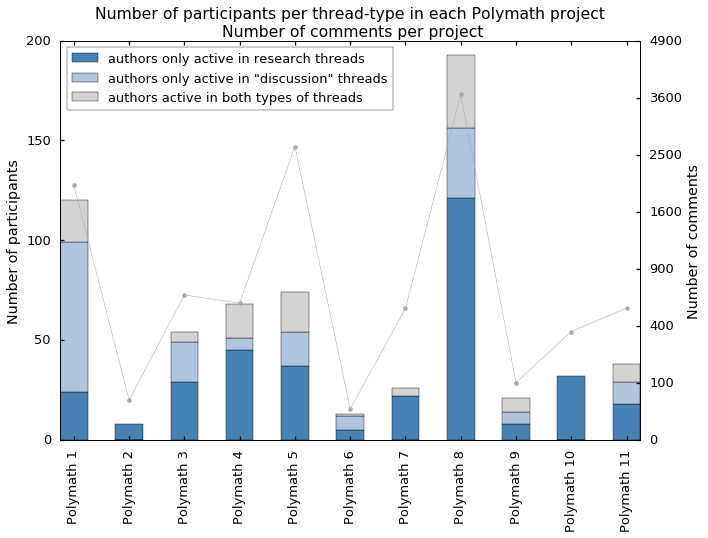

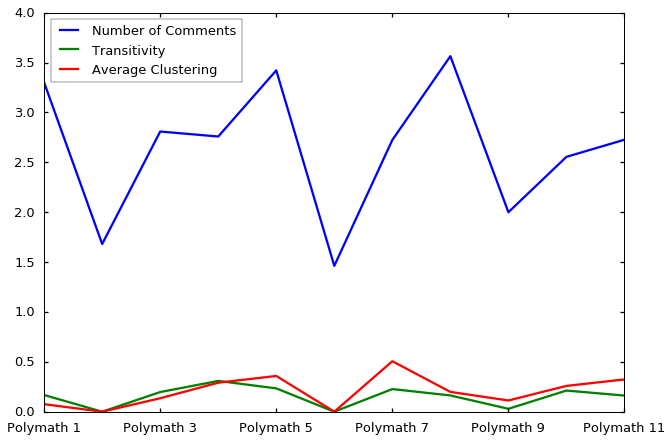

In [58]:
from matplotlib.ticker import FuncFormatter

PROJECTS_TO_C = ["Polymath {}".format(i) for i in range(1, len(POLYMATHS)+1)]
PARTICIPANTS = Series([PM_FRAME.loc[project]['authors (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C)
R_NETWORKS = Series([PM_FRAME.loc[project]['r_network'].dropna().iloc[-1] for project in PROJECTS_TO_C],
                    index=PROJECTS_TO_C)
WITH_D = [project for project in PROJECTS_TO_C if not PM_FRAME.loc[project]['research'].all()]
D_NETWORKS = Series([PM_FRAME.loc[project]['d_network'].dropna().iloc[-1] for project in WITH_D],
                    index=WITH_D)
R_PARTICIPANTS = R_NETWORKS.apply(lambda network: set(network.author_frame.index))
D_PARTICIPANTS = D_NETWORKS.apply(lambda network: set(network.author_frame.index))
COMMENTS = Series([PM_FRAME.loc[project]['number of comments (accumulated)'].iloc[-1] for
                project in PROJECTS_TO_C], index=PROJECTS_TO_C, name="Number of Comments")
GRAPHS = Series([PM_FRAME.loc[project]['network'].iloc[-1].graph.to_undirected() for project in PROJECTS_TO_C], index=PROJECTS_TO_C)
#TRIANGLES = GRAPHS.apply(nx.triangles)
#TRIANGLES.name = "Triangles"
TRANSITIVITY = Series([nx.transitivity(PM_FRAME.loc[project]['network'].iloc[-1].graph) for project in PROJECTS_TO_C], index=PROJECTS_TO_C)
TRANSITIVITY.name = "Transitivity"
AVG_CLUSTERING = GRAPHS.apply(nx.average_clustering)
AVG_CLUSTERING.name = "Average Clustering"

df = DataFrame({'all threads': PARTICIPANTS, 'research threads': R_PARTICIPANTS, 'discussion threads': D_PARTICIPANTS},
              index=PROJECTS_TO_C)
df['authors only active in research threads'] = df['research threads'] - df['discussion threads']
df['authors only active in "discussion" threads'] = df['discussion threads'] - df['research threads']
df['authors active in both types of threads'] = df['all threads'] - df['authors only active in research threads'] - df['authors only active in "discussion" threads']
for project in PROJECTS_TO_C:
    if pd.isnull(df.loc[project]['authors only active in research threads']):
        df.loc[project]['authors only active in research threads'] = df.loc[project]['all threads']
data = df[['authors only active in research threads', 'authors only active in "discussion" threads', 'authors active in both types of threads']]
data = data.applymap(lambda set: len(set) if pd.notnull(set) else 0)
matplotlib.style.use(SBSTYLE)
axes = data.plot(kind='bar', stacked=True, color=['steelblue', 'lightsteelblue', 'lightgrey'],
          title="Number of participants per thread-type in each Polymath project\n Number of comments per project")
axes.set_ylabel("Number of participants")
data2 = np.sqrt(COMMENTS)
axes2 = axes.twinx()
axes2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos:"{:0.0f}".format(np.square(x))))
axes2.set_ylabel("Number of comments")
axes2.plot(axes.get_xticks(), data2.values,
                   linestyle='-', marker='.', linewidth=.5,
                   color='darkgrey')
data3 = pd.concat([np.log10(COMMENTS), TRANSITIVITY, AVG_CLUSTERING], axis=1)
data3.plot(marker="+")
# TODO: improve style + make it a parallel-coordinates plot

### Comparing the growth of successful and unsuccessful projects

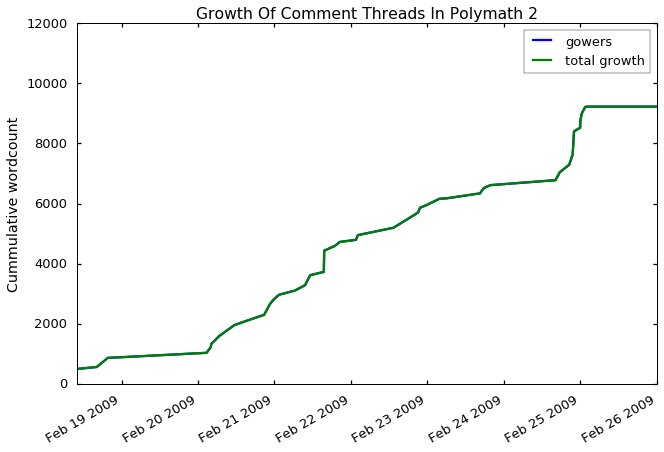

In [8]:
plot_growth("Polymath 2", last='2009-02-26')

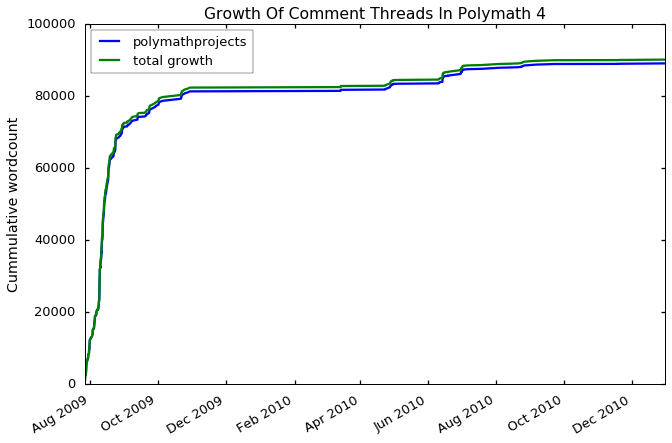

In [9]:
plot_growth("Polymath 4", last='2010-12-31')

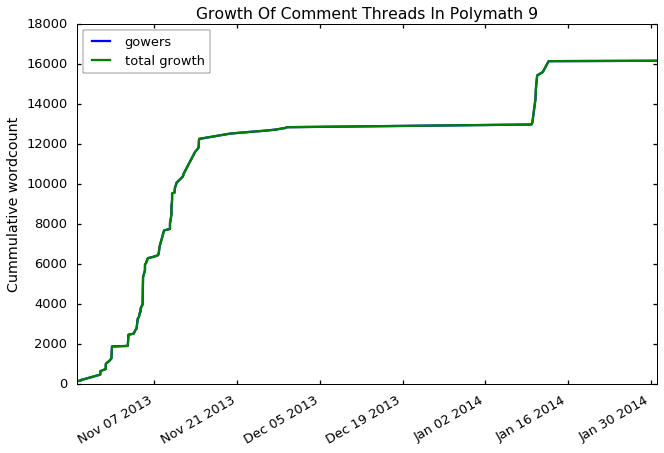

In [10]:
plot_growth("Polymath 9", last='2014-01-31')

## Evolution of the Community

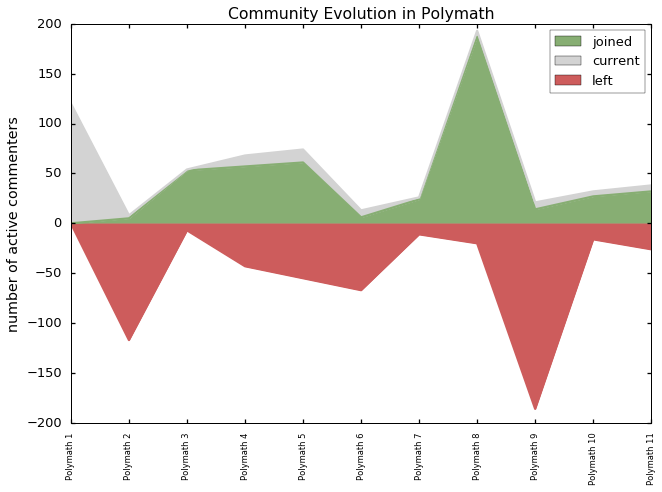

In [11]:
plot_community_evolution("Polymath")

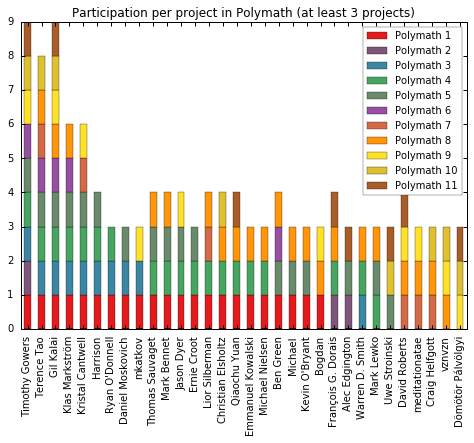

In [12]:
plot_participation_evolution("Polymath", n=3)

Small constant user-based that was established during the early stages.

## Polymath 1: Overview

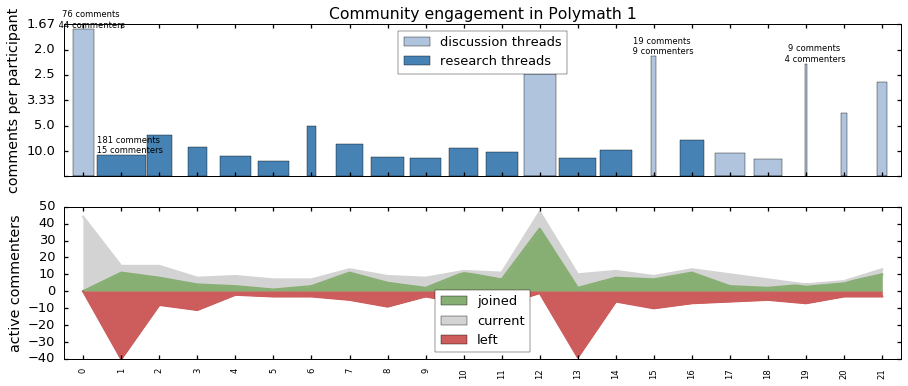

In [13]:
plot_thread_evolution("Polymath 1", compress=140, sel=[0, 1, 15, 19], sharex=True)

+ Highly diverse discussion-threads, but less diverse research-threads

+ Polymath 1 included parallel discussions, which may partially cause the variation in engagement.

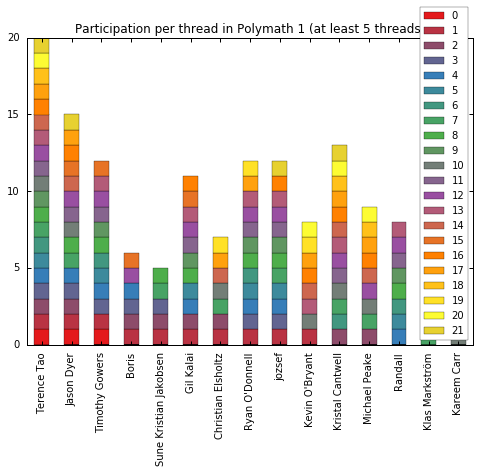

In [14]:
plot_participation_evolution("Polymath 1", n=5)

+ Only for "early adopters" (remains true if we reduce the lower-bound).
+ High cost for late-commers is a recurring theme in the literature.
+ Does not show how much was contributed to each thread.

## Polymath 1: Roles and activity

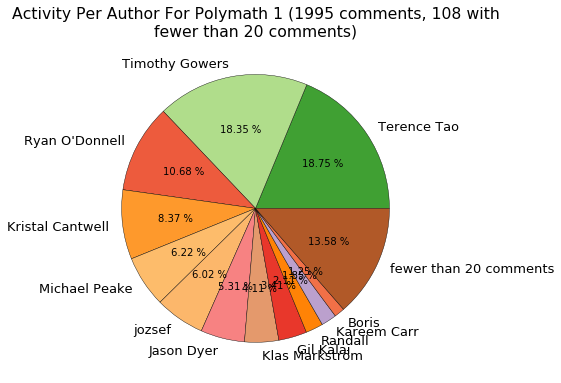

In [15]:
plot_activity_pie("Polymath 1")

Only 4 participants are responsible for over 50% of all comments.

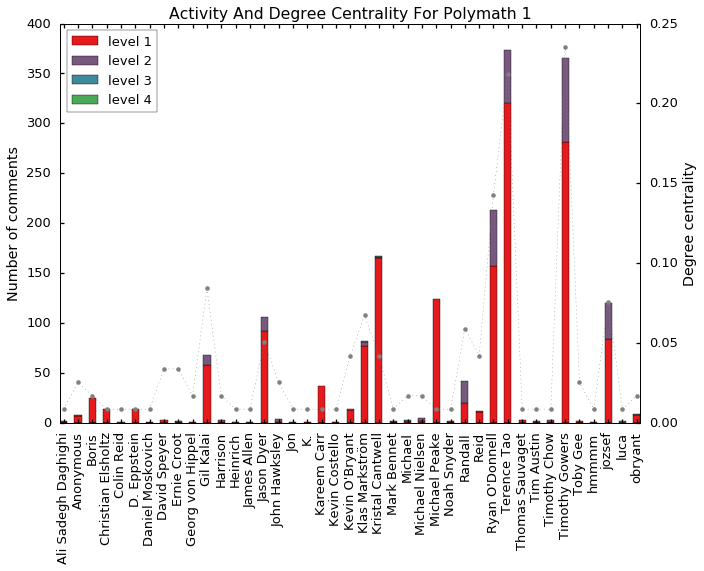

In [16]:
plot_activity_degree("Polymath 1")

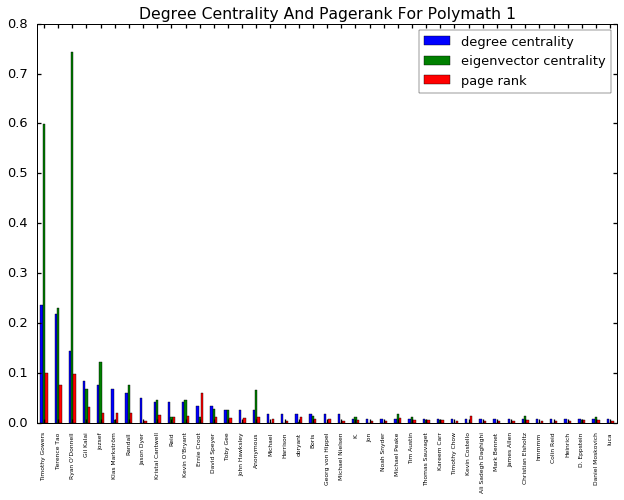

In [17]:
plot_degree_centrality("Polymath 1")

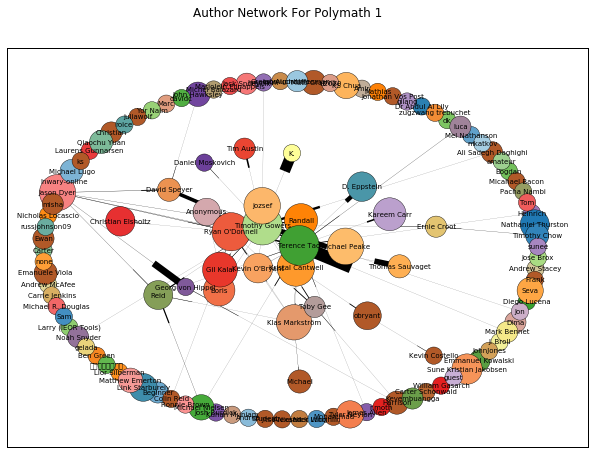

In [18]:
draw_network("Polymath 1")

Small "core" with large periphery.

## Polymath 1: A Closer Look

In [19]:
PM1_R = get_project_at("Polymath 1", 16)['r_network']
PM1_D = get_project_at("Polymath 1", -1)['d_network']

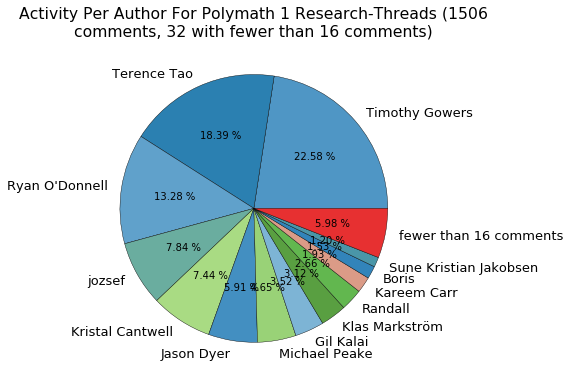

In [20]:
PM1_R.plot_author_activity_pie(project="Polymath 1 research-threads")

+ Commenting-activity is even more concentrated if we only look at research-threads.

+ But there are also fewer commenters who contributed only a little (less than 1% of the total number of comments).

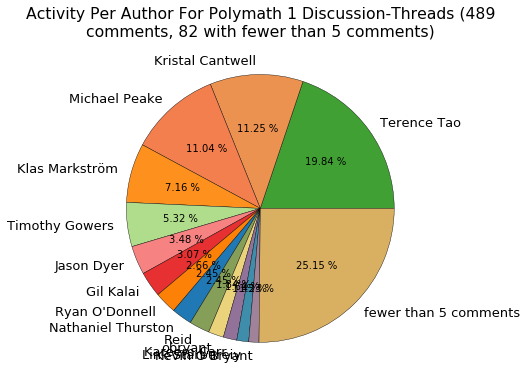

In [21]:
PM1_D.plot_author_activity_pie(project="Polymath 1 discussion-threads")

+ 50% is still contributed by a small group.

+ But 1 in 4 commenters contributed at most 1% of the total number of comments.

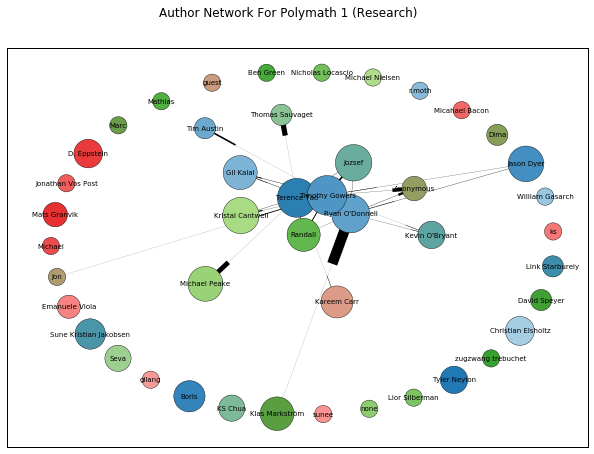

In [22]:
PM1_R.draw_graph(project="Polymath 1 (research)")

+ The periphery is much smaller if we only take the research-threads into account.

+ The "lack of connectivity" is an artefact of Polymath 1, where nested comments only became available at a later stage.

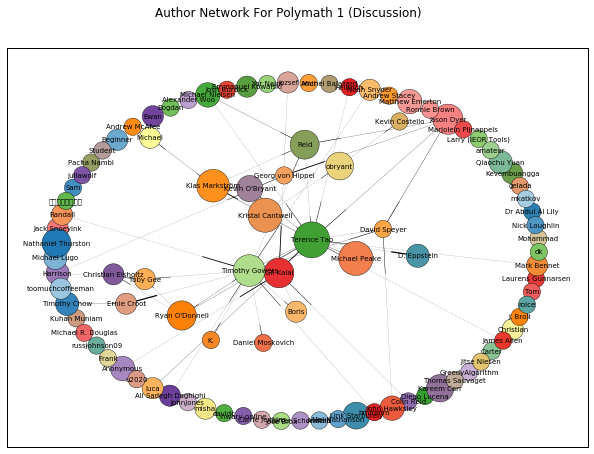

In [23]:
PM1_D.draw_graph(project="Polymath 1 (discussion)")

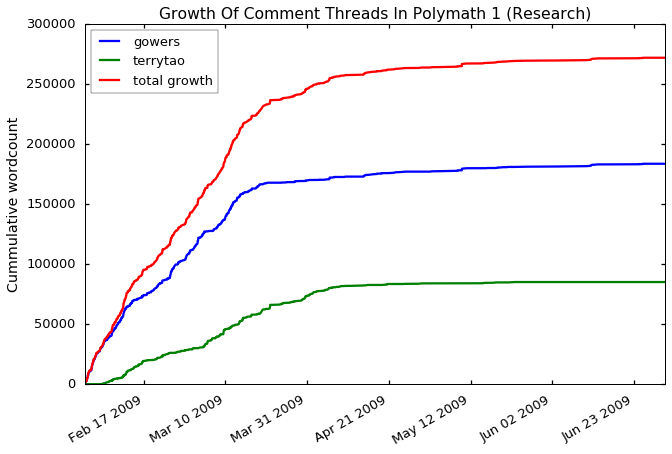

In [24]:
get_project_at("Polymath 1", 16)['r_mthread (accumulated)'].plot_growth(project="Polymath 1 (research)", last="2009-07-01")

Steady growth in the research-threads.

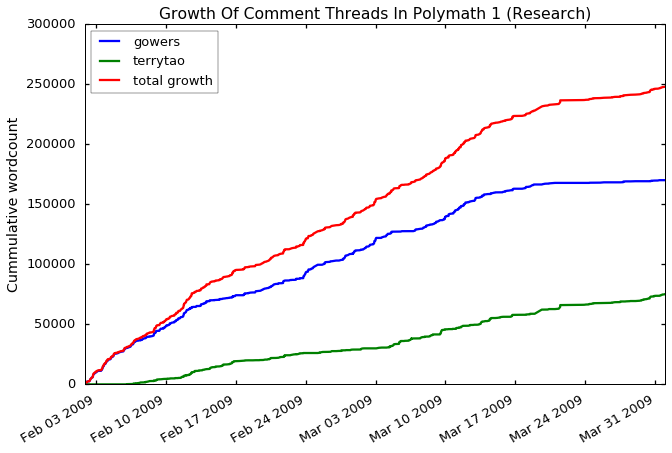

In [25]:
get_project_at("Polymath 1", 16)['r_mthread (accumulated)'].plot_growth(project="Polymath 1 (research)", last="2009-04-01")

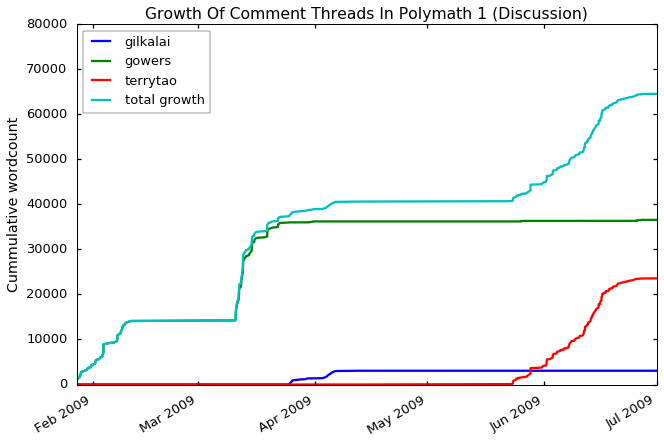

In [26]:
get_project_at("Polymath 1", -1)['d_mthread (accumulated)'].plot_growth(project="Polymath 1 (discussion)", last="2009-07-01")

Intense, but short discussion-threads between the research-threads.
+ Lower volume.
+ The two steep parts are threads 0 and thread 12.

## The parallel development in Polymath 1

In [27]:
PM_1 = PM_FRAME.loc['Polymath 1'].copy()
is_gowers = PM_1['blog']=='Gowers'
is_tao = PM_1['blog']=='Terrytao'
indices = PM_1.index
gow_indices = PM_1[is_gowers].index
tao_indices = PM_1[is_tao].index
threads = PM_1.thread
gow_threads = PM_1[is_gowers].thread
tao_threads = PM_1[is_tao].thread
PM_1['gow_mthread (accumulated)'] = Series([MultiCommentThread(*gow_threads[0:i+1]) for i in gow_indices],
                    index=gow_indices)
PM_1['tao_mthread (accumulated)'] = Series([MultiCommentThread(*tao_threads[0:i+1]) for i in tao_indices],
                    index=tao_indices)
PM_1['gow_network'] = PM_1[is_gowers]['gow_mthread (accumulated)'].apply(AuthorNetwork)
PM_1['tao_network'] = PM_1[is_tao]['tao_mthread (accumulated)'].apply(AuthorNetwork)


+ The discussion on Tao's blog happened in parrallel of the main discussion on Gowers' blog.

+ The question targetted on Tao's blog was different from the one on which Gowers focused.

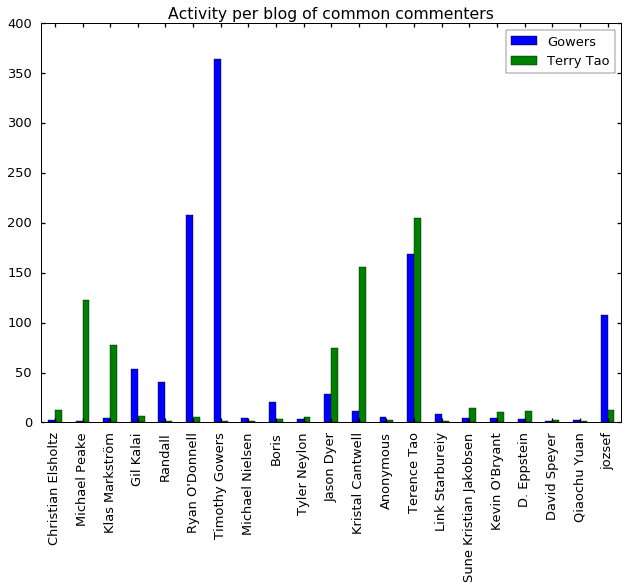

In [28]:
GOWERS = PM_1['gow_network'].dropna().iloc[-1].author_frame
TAO = PM_1['tao_network'].dropna().iloc[-1].author_frame

common = list(set(GOWERS.index).intersection(set(TAO.index)))
common_frame = DataFrame({'Gowers': GOWERS['total comments'][common],
                          'Terry Tao' : TAO['total comments'][common]})

matplotlib.style.use(SBSTYLE)
common_frame.plot(kind="bar", title="Activity per blog of common commenters")

+ As shown, Tao can be seen as the main *bridge* between both discussions.

+ If we focus on the network based on the research-threads, both Tao, O'Donnel and Gowers are *articulation-points*.

In [29]:
for i in nx.articulation_points(get_project_at("Polymath 1", 16)['r_network'].graph.to_undirected()):
    print(i)

Ryan O'Donnell
Timothy Gowers
Timothy Gowers
Terence Tao
Terence Tao
Terence Tao


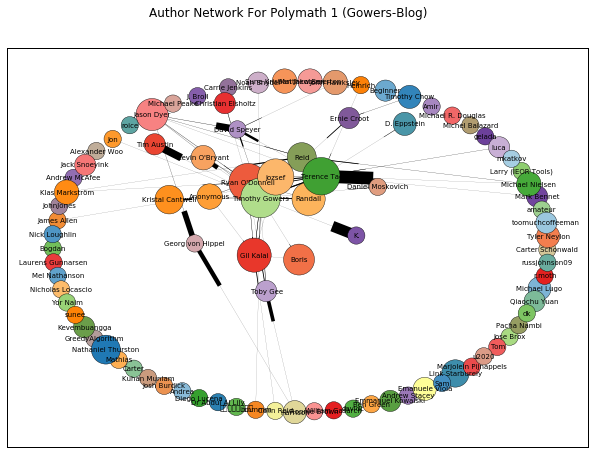

In [30]:
PM_1['gow_network'].dropna().iloc[-1].draw_graph(project="Polymath 1 (Gowers-blog)")

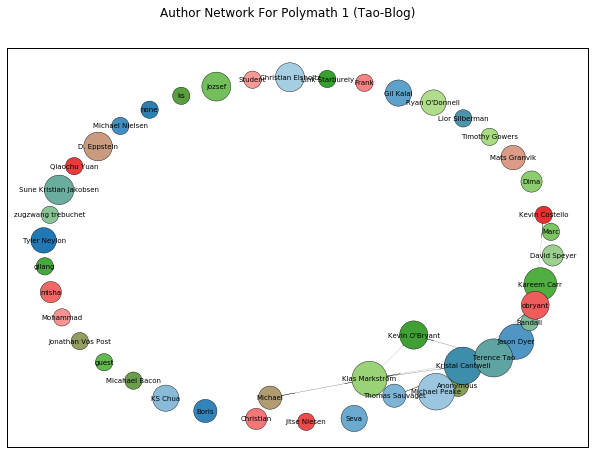

In [31]:
PM_1['tao_network'].dropna().iloc[-1].draw_graph(project="Polymath 1 (Tao-blog)")

## Polymath 4 as a point of comparison

+ Smaller, but successful project.

+ Fewer discussion-threads.

+ Everything happens on a single blog.

+ Genuinely nested discussion.

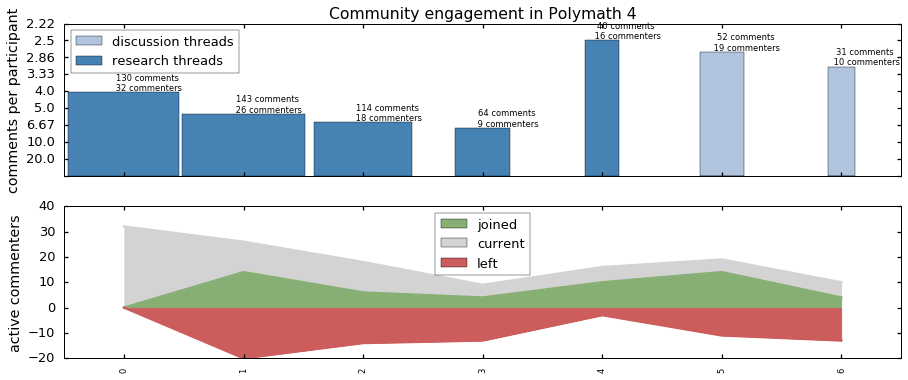

In [32]:
plot_thread_evolution("Polymath 4", compress=140, sel=[0, 1, 2, 3, 4, 5, 6], sharex=True)

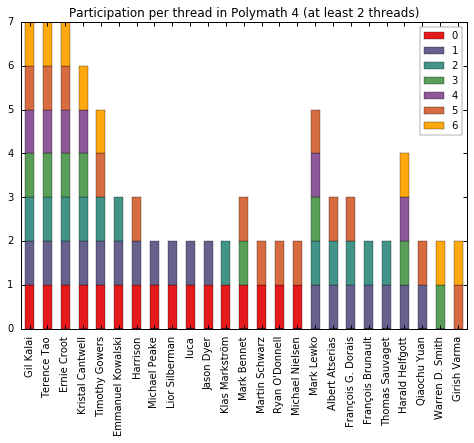

In [33]:
plot_participation_evolution("Polymath 4", n=2)

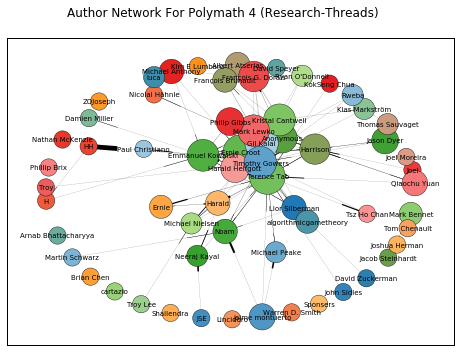

In [34]:
PM_FRAME.loc['Polymath 4']['r_network'].dropna().iloc[-1].draw_graph(project="Polymath 4 (research-threads)")

+ A single large weakly connected component of 47 participats.
+ A single large strongly connected component of 31 participants.

+ One weakly/strongly connected component of 2 participants (Mark Bennet, Jacob Steinhardt)

+ 13 not weakly connected participants.
+ 19 not strongly connected participants.

+ 12 articulation points (in undirected graph); not necessarily the most active participants.

In [35]:
set(nx.articulation_points(PM_FRAME.loc['Polymath 4']['r_network'].dropna().iloc[-1].graph.to_undirected()))

{'Albert Atserias',
 'Emmanuel Kowalski',
 'François G. Dorais',
 'Gil Kalai',
 'Klas Markström',
 'Lior Silberman',
 'Michael Nielsen',
 'Neeraj Kayal',
 'Noam',
 "Ryan O'Donnell",
 'Terence Tao',
 'Timothy Gowers'}

In [44]:
print("average clustering: ", nx.average_clustering(PM_FRAME.loc['Polymath 4']['r_network'].dropna().iloc[-1].graph.to_undirected()))
print("transitivity: ", nx.transitivity(PM_FRAME.loc['Polymath 4']['r_network'].dropna().iloc[-1].graph.to_undirected()))

average clustering:  0.307928854299822
transitivity:  0.33641618497109826


In [36]:
nx.strongly_connected_component_subgraphs(PM_FRAME.loc['Polymath 4']['r_network'].dropna().iloc[-1].graph, copy=True)

<generator object strongly_connected_component_subgraphs at 0x1c586a780>

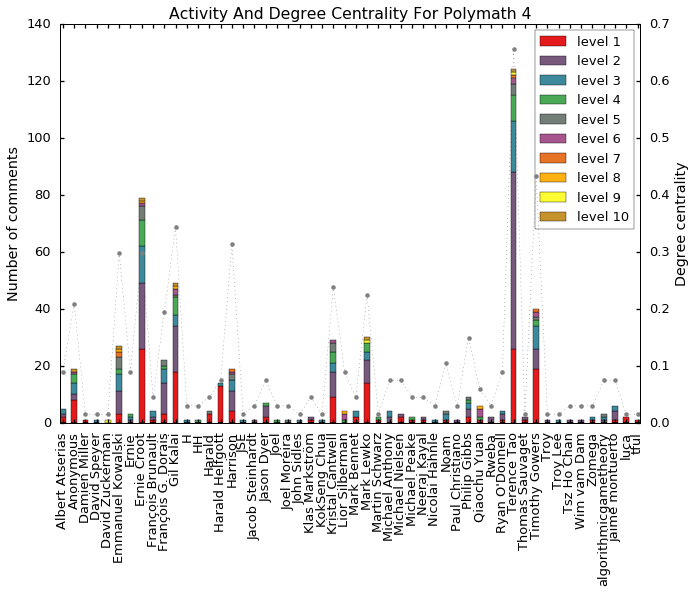

In [37]:
plot_activity_degree("Polymath 4")

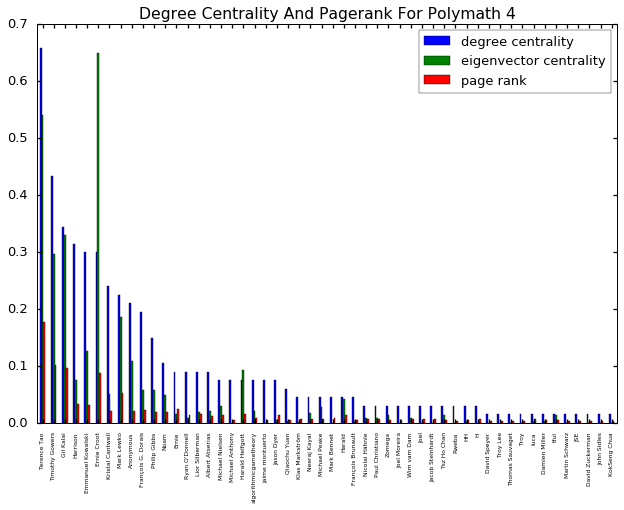

In [39]:
plot_degree_centrality("Polymath 4")

## The structure of communication in scientific communities

#### What is the optimal structure of communication (given certain assumptions) for a given epistemic aim?

+ Bala & Goyal model adapted by Zollman.

+ Communities are represented as graphs.

+ Individual agents are Bayesian learners.

+ Success = converging to the truth.

+ Main insight: maximal connectivity is *not* the optimal organisation (being shielded from potentially bad information is beneficial).

+ Further insights depend on the assumptions that are made (size of the community, cost of communication, reliability of communication).

#### The associated typology of communities is graph-based

+ Two communities are different if their associated graphs are not isomorphic.

+ Because connections are "available channels", Polymath seems to lead to maximal connectivity (all information is public).  

+ This is not optimal, but it is also not reflected in the actual communication-patterns.

+ Further obstacles:
    + more complex problem (not merely choosing between alternatives).
    + epistemic cost for latecommers limits the potential benefit of maximal connectivity.
    + interactions are replies instead of *mere observations*.
    + information about *who reads what* is not directly available.

## Announcement-types as an alternative typology?

#### Why?

+ "Mere access" does not explain why and how Polymath works.

+ We only know who's "talking," but not who's listening.

+ We're interested in collaboration, and not just in information-flow (collaborative problem-solving is not just judgement aggregation).

+ Finer typology of group-structure by looking at patterns of one-to-many communication.

#### Proposal: focus on the role of group-attitudes

+ Typical attitudes associated with *teamwork* are:
    + Mutual intentions
    + Common intentions
    + Group commitments

+ Insights from "Logics from teamwork":

$\mathsf{M\text{-}INT}_G \phi \leftrightarrow \mathsf{E\text{-}INT}_G (\phi \wedge \mathsf{M\text{-}INT}_G \phi)$

$\mathsf{C\text{-}INT}_G \phi \leftrightarrow \mathsf{M\text{-}INT}_G \phi \wedge \mathsf{Aw}_G (\mathsf{M\text{-}INT}_G \phi)$


$\mathsf{COMM}(i, j, \phi) \to \mathsf{C\text{-}BEL}_{\{i, j\}} \mathsf{COMM}(i, j, \phi)$

+ This underscores the importance of higher-order attitudes for successful collaboration.

+ But common-attitudes are special in the sense that they can only be achieved through *public announcements*.

## Asynchronic communication versus the needs and apparence of public communication

#### What we expect

+ Leading figures can *set the agenda*.

+ Setting the agenda means creating common goals.

+ Common goals require common attitudes, and hence public announcements.

#### What can be expected

+ Blog-communication is asynchronous communication.

+ Common attitudes are out of reach.

#### But there is hope

+ Perhaps something weaker is sufficient (Dunin-Keplicz & Verbrugge explicitly consider this).

+ The actual success of Polymath suggests that blog-interaction can be used for team-work (but there is also an explicit record of why it is difficult).

+ At least the blog-posts (as opposed to the comments) should qualify as public announcements.

#### A proposal

+ The success of Polymath does not just result from how central figures create a common ground from a diverse input.

+ The crucial aspect is that central figures are powerful aggregators...

+ ... that can always be reached by the participants.

+ Not only can central figures reliably reach a large subset of the participants (one-to-many), the participants can also relaibly reach the central figures (one-to-one).

+ Even more: all participants can with a high probability reach those who have recently been active (supported by high speed of interaction).

+ Hence, even if the cost of contributing may be high, there is a guarantee of being heard (by the most powerful, best informed, ...).

## The "centre of discussion" metaphor

+ If *A* just contributed, *A* is at the centre of discussion.

+ How far *A* is from the centre of discussion depends on the time ellapsed since the last intervention.

+ The probability of being heard by *A* depends on how far *A* is from the centre.

+ This creates a basis of localised, probable public announcements.

+ But it is also something we can actually investigate.

In [38]:
import io
import base64
from IPython.display import HTML

video = io.open('FIGS/out.mp4', 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

## Centre of discussion visualised
<img src="FIGS/img00005.png">

## Conclusion

+ We can mix formal and data-driven investigation.

+ Polymath is a valuable, but also an unusual case of e-research (ask me if you want to know more).

+ There should be opportunities to introduce formal insights into computational social science that looks at how information flows in communities.